# Pricing Optimization to Maximize Revenue

* Packages: `PyMC`, `ArviZ`
* Approches: Bayesian Statistics to include our **_prioir beliefs_**, **_evidence_**, **_likelihood_** and **_posterior_**, and **Marove Chain Monte Carlo (MCMC)** to gives a probabilistic estimate rather than a single fixed model.
* Data Source: [Train Ticket Datset](https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/renfe_small.csv)
* Reference: [Hands On Bayesian Statistics with Python, PyMC3 & ArviZ](https://medium.com/towards-data-science/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501)

## Step 1. Define the pricing problem
Goal: Determine the optimal ticket price that maximizes revenue

* Revnue formula: 

$Revenue = Price * Demand$


* As the demand is uncertain and depends on price, we use Bayesian staistics:

$Demand (Basic) = Base Demand + Price Sensitivity * Price + Noise$


* Price depends on multiple factors:
    * higher **train class** may have lower price sensitivity 
    * fare type could influence demand elasticity
    * train type: faster trains may have different pricing dynamics
    * seasonality: holidy and weekends may affect demand

$Price = Baseline Price + Price Sensitivity_1 * Price + Price Sensitivity_2 * Train Class + Price Sensitivity_3 * Fare Type + Noise$  




In [4]:
!pip install scikit-learn pymc arviz pandas matplotlib seaborn numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 36.2 MB/s eta 0:00:0000:0100:01
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip uninstall theano pymc3 aesara arviz -y
!pip install --upgrade pymc aesara arviz

Found existing installation: pymc3 3.11.6
Uninstalling pymc3-3.11.6:
  Successfully uninstalled pymc3-3.11.6
Found existing installation: arviz 0.20.0
Uninstalling arviz-0.20.0:
  Successfully uninstalled arviz-0.20.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.3 MB/s eta 0:00:0000:010:01
  Using cached arviz-0.20.0-py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 21.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.1
    Uninstalling scipy-1.15.1:
      Successfully uninstalled scipy-1.15.1

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install numba #running PyMC on Mac M1/M2 to improve efficiency


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [6]:
from scipy import stats
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
# from theano import shared
from sklearn import preprocessing

print('Running on PyMC v{}'.format(pm.__version__))

# Ensure plots display in Jupyter Notebook
%matplotlib inline

Running on PyMC v5.20.0


## Step 2. Collect and Prepare Data
Feature Engineering and deal with missing data.

In [113]:
url = 'https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/renfe_small.csv'

# Read csv from url
df = pd.read_csv(url)
print(df.head())

           insert_date    origin destination           start_date  \
0  2019-04-22 08:00:25    MADRID     SEVILLA  2019-04-28 08:30:00   
1  2019-04-22 10:03:24    MADRID    VALENCIA  2019-05-20 06:45:00   
2  2019-04-25 19:19:46    MADRID     SEVILLA  2019-05-29 06:20:00   
3  2019-04-24 06:21:57   SEVILLA      MADRID  2019-05-03 08:35:00   
4  2019-04-19 21:13:55  VALENCIA      MADRID  2019-05-10 09:40:00   

              end_date train_type  price         train_class      fare  
0  2019-04-28 11:14:00      ALVIA    NaN             Turista  Flexible  
1  2019-05-20 08:38:00        AVE  21.95             Turista     Promo  
2  2019-05-29 09:16:00    AV City  38.55             Turista     Promo  
3  2019-05-03 15:26:00      LD-MD  34.35  Turista con enlace   Promo +  
4  2019-05-10 11:20:00        AVE  45.30             Turista     Promo  


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25798 entries, 0 to 25797
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   insert_date  25798 non-null  object 
 1   origin       25798 non-null  object 
 2   destination  25798 non-null  object 
 3   start_date   25798 non-null  object 
 4   end_date     25798 non-null  object 
 5   train_type   25798 non-null  object 
 6   price        22716 non-null  float64
 7   train_class  25695 non-null  object 
 8   fare         25695 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.8+ MB


In [62]:
# set as datetime
for i in ['start_date', 'end_date']:
    df[i] = pd.to_datetime(df[i])

In [7]:
df.isnull().sum()/len(df)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.119467
train_class    0.003993
fare           0.003993
dtype: float64

#### Fill the missing value:

In [9]:
print(df['train_class'].mode())
print(df['train_class'].unique())

0    Turista
Name: train_class, dtype: object
['Turista' 'Turista con enlace' 'Preferente' 'Turista Plus' nan
 'Cama Turista' 'Cama G. Clase']


In [63]:
df['train_class'] = df['train_class'].fillna(df['train_class'].mode().iloc[0]) #.iloc[0] if there's multiple mode value, select the first returning from the Series
df['fare'] = df['fare'].fillna(df['fare'].mode().iloc[0]) 
# Group by fare type and imput the mean value of its type
df['price'] = df.groupby('fare')['price'].transform(lambda x: x.fillna(x.mean()))

In [14]:
df.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,2019-04-22 08:00:25,MADRID,SEVILLA,2019-04-28 08:30:00,2019-04-28 11:14:00,ALVIA,82.077189,Turista,Flexible
1,2019-04-22 10:03:24,MADRID,VALENCIA,2019-05-20 06:45:00,2019-05-20 08:38:00,AVE,21.950000,Turista,Promo
2,2019-04-25 19:19:46,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.550000,Turista,Promo
3,2019-04-24 06:21:57,SEVILLA,MADRID,2019-05-03 08:35:00,2019-05-03 15:26:00,LD-MD,34.350000,Turista con enlace,Promo +
4,2019-04-19 21:13:55,VALENCIA,MADRID,2019-05-10 09:40:00,2019-05-10 11:20:00,AVE,45.300000,Turista,Promo


In [ ]:
# df.isnull().sum()

#### Label Encoding: Convert Categorical Features to Numeric
Bayesian models in PyMC3 (or any statistical models) in general requires numeric data, and reduce computataion complexity. 
* `astype('category').cat.codes` is reversible and easty to map back to original labels.
* May not be that suitable to use one-hot encoding that brings in a wide table.

In [114]:
features = ['train_type', 'train_class', 'fare']
mapping = {} # Dictionary to store mappings

for i in features:
    df[i] = df[i].astype('category')
    # Store mapping
    mapping[i] = dict(enumerate(df[i].cat.categories))
    # Convert to numeric
    df[i] = df[i].cat.codes 

In [115]:
mapping

{'train_type': {0: 'ALVIA',
  1: 'AV City',
  2: 'AVE',
  3: 'AVE-LD',
  4: 'AVE-MD',
  5: 'AVE-TGV',
  6: 'INTERCITY',
  7: 'LD',
  8: 'LD-AVE',
  9: 'LD-MD',
  10: 'MD',
  11: 'MD-AVE',
  12: 'MD-LD',
  13: 'R. EXPRES',
  14: 'REGIONAL',
  15: 'TRENHOTEL'},
 'train_class': {0: 'Cama G. Clase',
  1: 'Cama Turista',
  2: 'Preferente',
  3: 'Turista',
  4: 'Turista Plus',
  5: 'Turista con enlace'},
 'fare': {0: 'Adulto ida',
  1: 'Flexible',
  2: 'Individual-Flexible',
  3: 'Mesa',
  4: 'Promo',
  5: 'Promo +'}}

#### EDA: Gaussian Inferences


In [17]:
df.price.describe()

count    25798.000000
mean        64.106530
std         24.720684
min         16.600000
25%         45.300000
50%         62.442987
75%         80.150000
max        214.200000
Name: price, dtype: float64

In [18]:
df.price.mean() * len(df)

1653820.2694076092

/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_8123/3850296306.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['price'], palette='Set2')
/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_8123/3850296306.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['price'], palette='Set2')
/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_8123/3850296306.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['price'], palette='Set2')


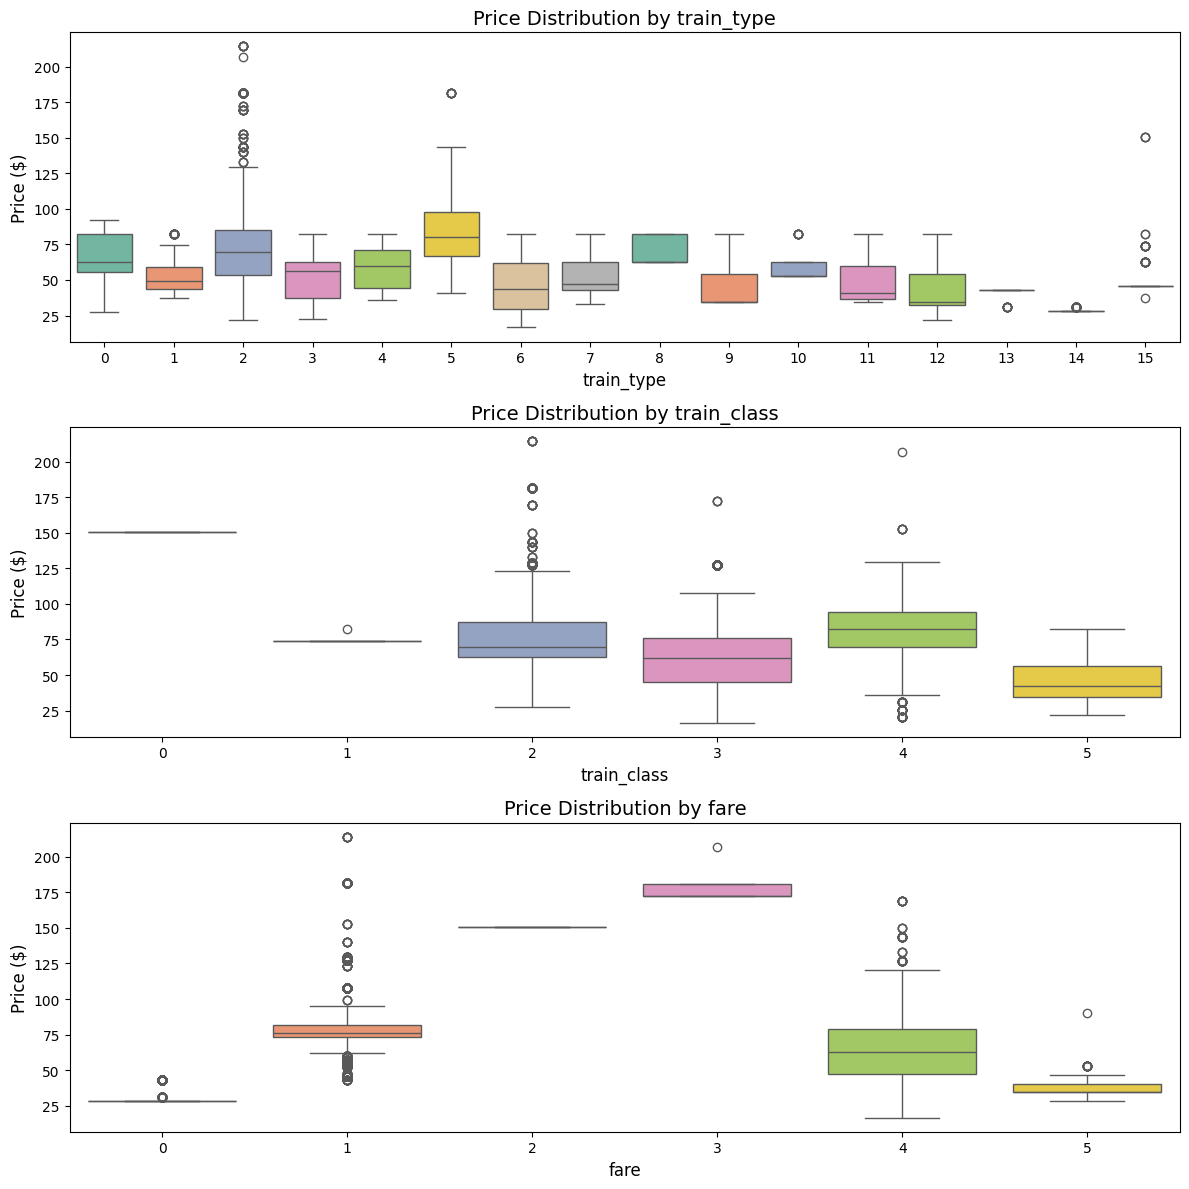

In [26]:
# set figsize
plt.figure(figsize=(12, 4 * len(features)))

# loop through features
for i, col in enumerate(features, 1):
    plt.subplot(len(features), 1, i) # Create subplots
    sns.boxplot(x=df[col], y=df['price'], palette='Set2')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.title(f'Price Distribution by {col}', fontsize=14)

plt.tight_layout()
plt.show()

In [45]:
df[['fare', 'price', 'train_type',]].corr(method='spearman')

,fare,price,train_type
fare,1.000000,-0.113932,-0.238619
price,-0.113932,1.000000,-0.316915
train_type,-0.238619,-0.316915,1.000000


## Step 3. Define & Train the Bayesian Model
Assume the ticket price will follow normal distribution, formed by linear regression with factors of independent variables with the same variance.

1. Prior Distribution: As **Bayesian Inference** is built on prior knowledge, could NOT use the **empirical mean and standard deviation** we found earlier but estimation

    * Assign priors to unkown parameters based on domain knowledge. For example: $α,β∼N(0,10)$
    * **$α$ is the base price**. I set the boundaries of price range between $10 and $300, with a standard deviation of $20.
    * **$β$ captures how features affect price**. (assumed normal prior at -2: demand decreases as price rises)

<br/>

2. Likelihood Function: 
    * The demand can be modeled as: $$Demand=α+β*Price+ϵ$$
    * where $ϵ∼N(0,σ^2)$ captures noise.

<br/>

3. Posterior Distribution:
    * Using `PyMC3`, sample from the posterior to estimate price elasticity.


#### Train the model:
1. Use `Markove Chain Monte Carlo (MCMC)` sampling (eg. `NUTS sampler` in `PYMC3`) to estimate the posterior distribution.
2. Evaluate convergence using diagnostics like:
    * Trace plots
    * Autocorrelation plots
    * Gelman-Rubin statistic

In [19]:
df.columns

Index(['insert_date', 'origin', 'destination', 'start_date', 'end_date',
       'train_type', 'price', 'train_class', 'fare'],
      dtype='object')

In [ ]:
# Define Bayesian Regression Model using PyMC3
with pm.Model() as model:
    # Step 1. Prioir belief
    # Baseline price: the expected deman when tieck price is at $0 (assumed following a normal distribution at 100 and uncertainty (sigma=20))
    alpha = pm.Normal('alpha', mu=100, sigma=50)#df['price'].mean(), sigma=df['price'].std()) # Baseline price
    # Price sensitivity by fare type
    beta_fare = pm.Normal('beta_fare', mu=0, sigma=2) # Fare type effect
    beta_class = pm.Normal('beta_class', mu=0, sigma=2) # Train class effect
    beta_train = pm.Normal('beta_train', mu=0, sigma=2) # Train type effect
    # Noise: uncertainty in demand due to external factors (HalfNormal distribution: only positive values)
    sigma = pm.HalfNormal('sigma', sigma=50) #sigma=df['price'].std()) 
    
    # Step 2. Define likihood function
    # Expected price equation:
    price_mu = (alpha + beta_fare * df['fare'] + beta_class * df['train_class']+ beta_train * df['train_type']) 
    
    # likelihood: assume observed demand follows a normal distribution around `demand_mu` with uncertainty `sigma`
    price_obs = pm.Normal('price_obs', mu=price_mu, sigma=sigma, observed=df['price'])
    
    # Sampling using MCMC to estimate the posterior distributions of `alpha`, `beta` and `sigma`
    """pm.sample(draw, chains, tune, random_seed)
    draw (posterior samples): the number of samples to draw from the posterior distribution, default as 1,000 (after tuning, the next 1,000 samples are kept as posterior estimates)
    chains: the number of independent Markov chains to run, default as 4
    tune (burn-in phase): the number of iterations to use for tuning the sampler (then are discarded), default as 1,000 -> higher tune could help the model to converge
    random_seed: random number generator
    return_inference=True: converts results into an ArviZ `InferenceData` object, making it easier to analyze
    """
    trace = pm.sample(1000, return_inferencedata=True) #2000 samples are drawn to approximate the true demand function
    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_fare, beta_class, beta_train, sigma=]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


* 4 chains: PyMC runs multiple independent MCMC chains (helps detect sampling issues)
* 1_000  tune sample per chain -> total of 4,000
* 1_000 draw per chain -> total of 4,000
* total computation time: 31 seconds (depend on model complexity and CPU/GPU speed)

#### Model Diagnostics: Check Posterior Distributions

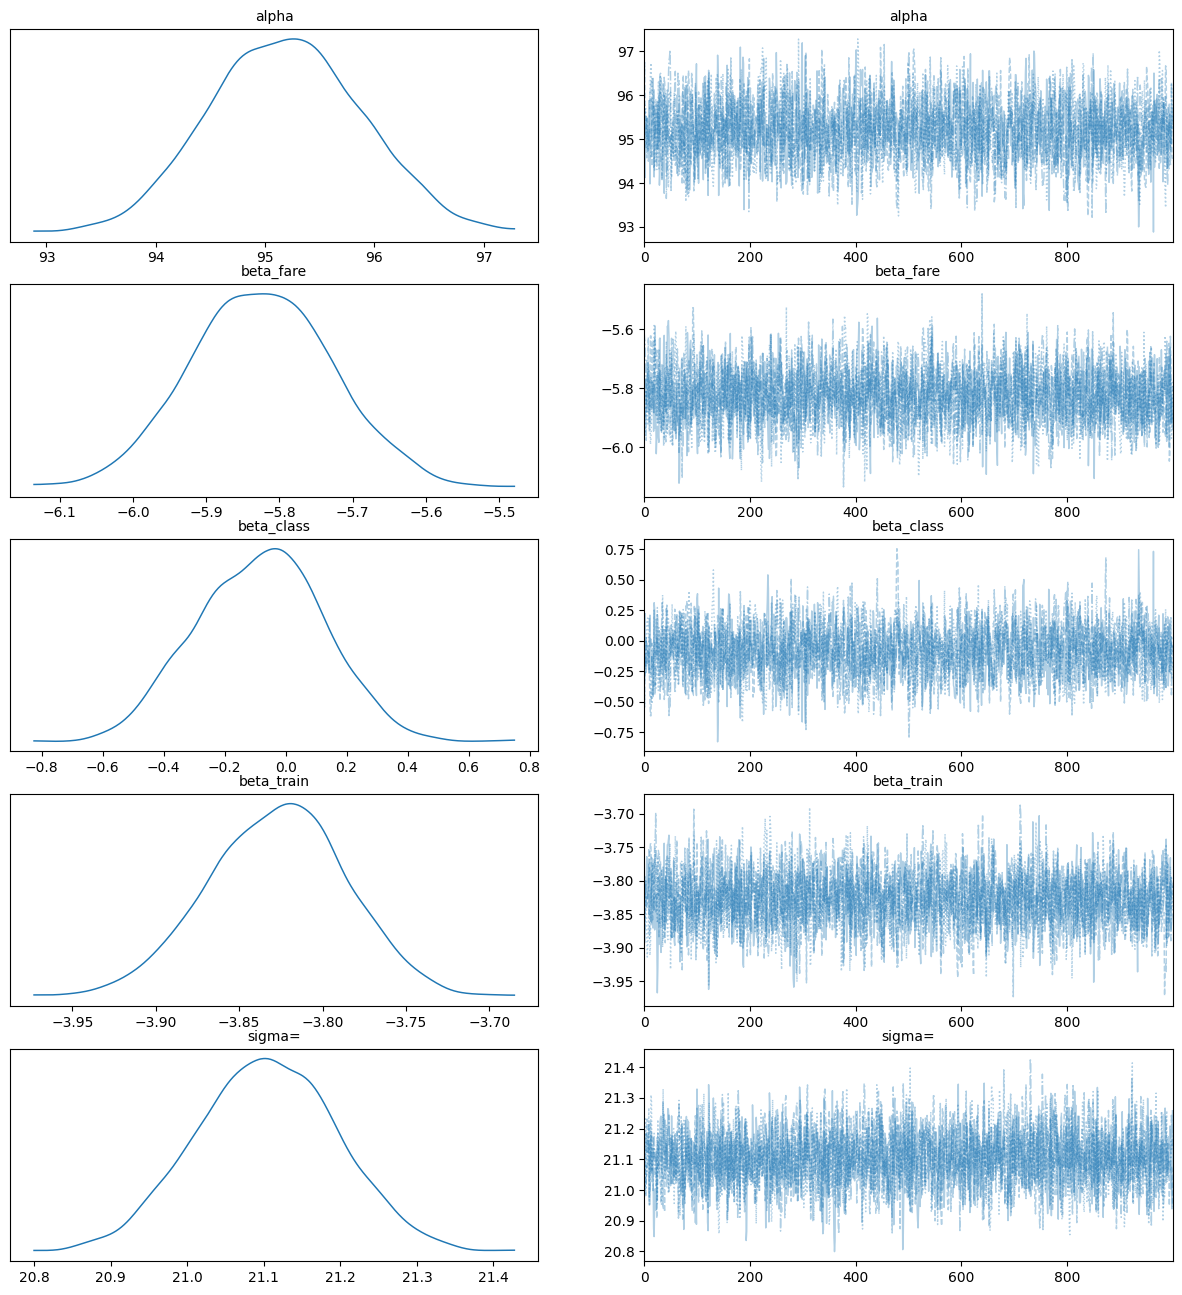

In [31]:
az.plot_trace(trace, figsize=(15,16), combined=True) # larger plots combine chains
# Adjust font size
plt.rcParams.update({'axes.labelsize': 12, 'axes.titlesize':14})
plt.show()

* Right-side: `MCMC Chain Plot for convergence`: shown as a hairy caterpillar without big jumps, meaning good mixing. -> It seems that individual parameters converged and stationary
    * (if long streaks of similar values; drifting chains -> the model has convergence issues)
* Left-side: `Posterior Distribution Plot`: Show the estimated distribution of each parameter; peak represents the most probable value for that parameter. 
    * wider distributions mean more uncertainty, and it means that the model needs more data or better priors.
    * The current plot looks smooth and unmodel distributions


In [21]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,95.192,0.689,93.949,96.492,0.015,0.011,2076.0,2208.0,1.0
beta_fare,-5.825,0.097,-6.001,-5.640,0.002,0.001,2425.0,2597.0,1.0
beta_class,-0.083,0.209,-0.457,0.311,0.005,0.003,1981.0,2461.0,1.0
beta_train,-3.827,0.042,-3.905,-3.749,0.001,0.001,2465.0,2662.0,1.0
sigma=,21.103,0.092,20.929,21.270,0.002,0.001,3067.0,2711.0,1.0


#### Posterior distributions with summary statistics

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_fare'}>,
        <Axes: title={'center': 'beta_class'}>],
       [<Axes: title={'center': 'beta_train'}>,
        <Axes: title={'center': 'sigma='}>, <Axes: >]], dtype=object)

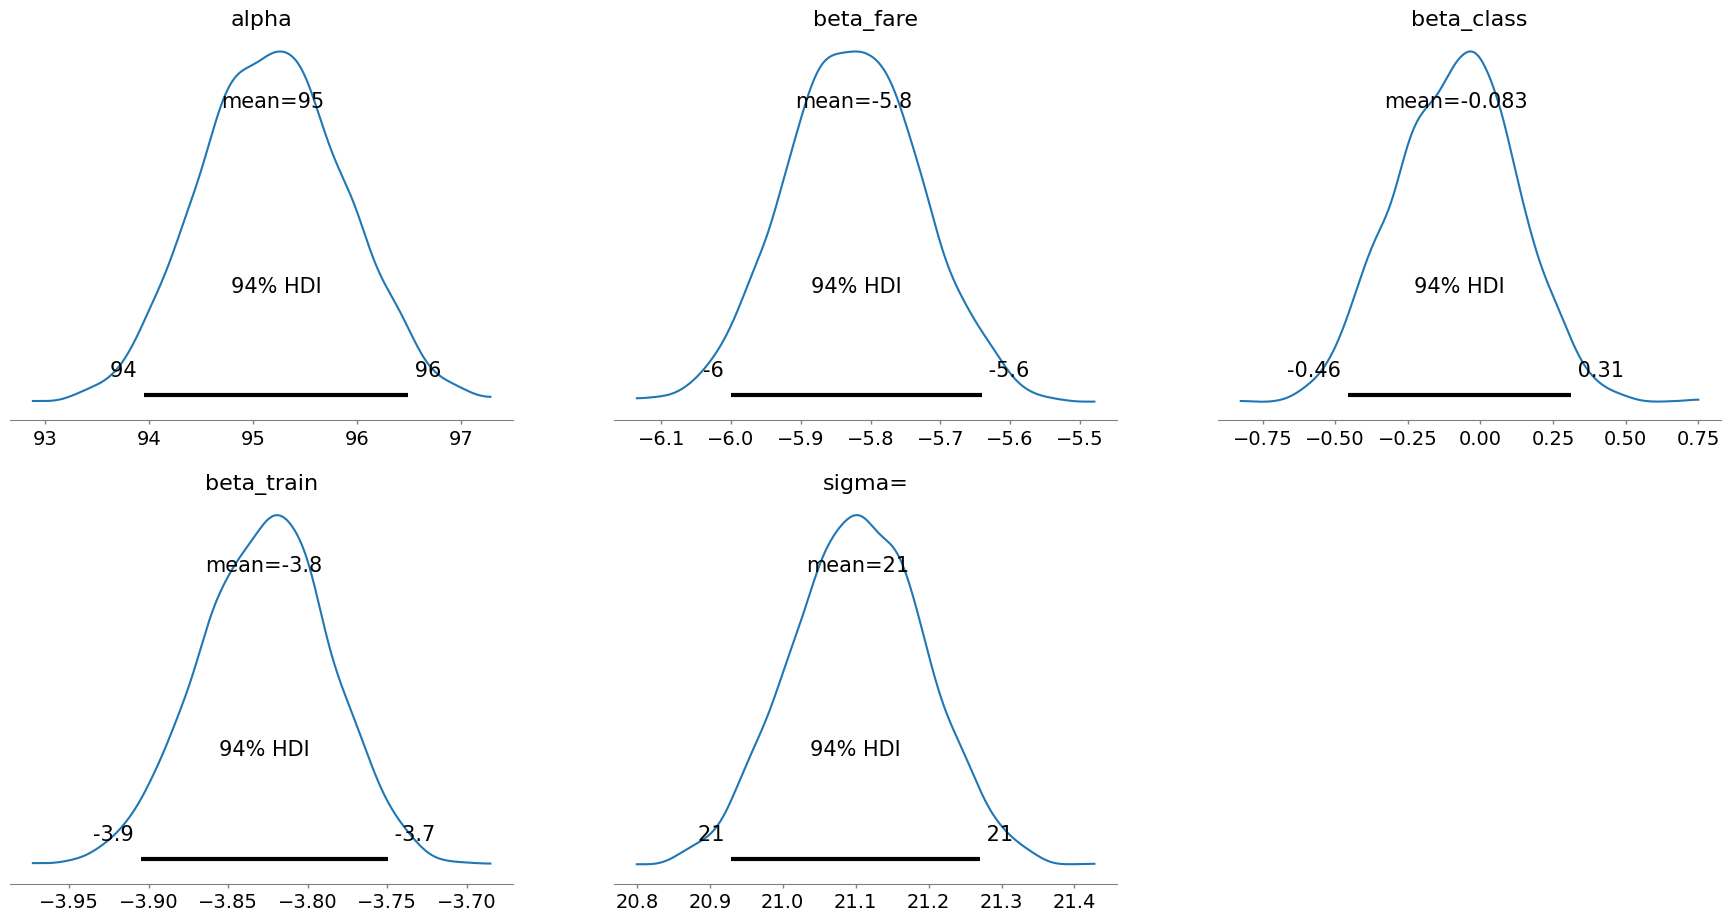

In [23]:
az.plot_posterior(trace)

* `alpha=95`: as the baseline price, 94% of Highest Density Interval (HDI) is [94, 96], meaning we are highly confident that the true value is in this range.
* `beta_fare=-5.8`: fare type significantly reduces price; HDI of [-6, -5.6] means strong confidence.
* `beta_class=-0.083`: very close to 0, meaning that train class has little effect on pricel HDI include 0, indicating that the train class has no real effect.
* `beta_train=-3.8`: train type reduces price; but less effect than beta_fare

#### Check if chains converge

In [46]:
az.rhat(trace)

<xarray.Dataset>
Dimensions:     ()
Data variables:
    alpha       float64 1.002
    beta_fare   float64 0.9998
    beta_class  float64 1.003
    beta_train  float64 1.001
    sigma=      float64 1.001

* If R-hat is about 1, Chains have converged.
* If R-hat > 1.1, Chains didn't mix well, increse `tune` or improve priors.

## 5. Interpret and Optimize
1. Estiamte Price Elasticity:
    * The posterior estimates for $β$ tell us how much price chnages when features changes.
    * If $β < 0$, price decreases with positive features change.

<br/>

2. Find Optimal Price for Maximum Revenue:
    * Compute expected revenue for different prices: $$E[Revenue]= Price * E[Demand | Price]$$
    * Identify the price where revenue is maximized.

<br/>

3. Uncertainty Quantification:
    * Use credible intervals to estimate confidence in pricing decisions.

In [118]:
for i, map in mapping.items():
    print(f'{i}:{map}')

Adulto ida:0
Flexible:1
Individual-Flexible:2
Mesa:3
Promo:4
Promo +:5


In [116]:
reverse_mappings = {i: {v: k for k, v in mapping[i].items()} for i in mapping}

# for i in features:
#     df[i] = df[i].map(reverse_mappings[i])

In [117]:
for key, mapping in reverse_mappings.items():
    print(f"{key}: {mapping}")

train_type: {'ALVIA': 0, 'AV City': 1, 'AVE': 2, 'AVE-LD': 3, 'AVE-MD': 4, 'AVE-TGV': 5, 'INTERCITY': 6, 'LD': 7, 'LD-AVE': 8, 'LD-MD': 9, 'MD': 10, 'MD-AVE': 11, 'MD-LD': 12, 'R. EXPRES': 13, 'REGIONAL': 14, 'TRENHOTEL': 15}
train_class: {'Cama G. Clase': 0, 'Cama Turista': 1, 'Preferente': 2, 'Turista': 3, 'Turista Plus': 4, 'Turista con enlace': 5}
fare: {'Adulto ida': 0, 'Flexible': 1, 'Individual-Flexible': 2, 'Mesa': 3, 'Promo': 4, 'Promo +': 5}


In [90]:
# Compute expected revenue & optimize pricing
# Extract posterior samples
posterior_samples = trace.posterior

# Estimate demand as a function of price from the posterior samples (reshape to ensure broadcasting)
price_range = np.linspace(10, 300, 50).reshape(-1,1) # Prices range to evaluate #reshape to (50,1)
alpha_mean = posterior_samples['alpha'].mean().item() 
beta_fare_mean = posterior_samples['beta_fare'].mean().item() 
beta_class_mean = posterior_samples['beta_class'].mean().item() 
beta_train_mean = posterior_samples['beta_train'].mean().item() 
"""This mean value and _code are scalars, biut price range is a NumPy array--need fix
`item()` to prevent shape mismatches;
"""

# Get unique encoded values
fare_types = df['fare'].unique()
train_classes = df['train_class'].unique()
train_types = df['train_type'].unique()

# Assume demand follows an exponential decay with price (based on realistic case)
# expected_demand = np.exp(alpha_mean - beta_fare_mean * price_range - beta_class_mean * price_range - beta_train_mean * price_range)
revenue_results = {}

for fare_code in fare_types:
    for class_code in train_classes:
        for train_code in train_types:
            
            # Ensure category code are cast to correct type as in reverse_mapping
            # fare_code = int(fare_code) if fare_code in reverse_mappings['fare'] else str(fare_code)
            # class_code = int(class_code) if class_code in reverse_mappings['train_class'] else str(class_code)
            # train_code = int(train_code) if train_code in reverse_mappings['train_type'] else str(train_code)
            
            # Check if mapping exist before using
            try:
                fare_label = mapping['fare'].get(fare_code, f"Unknown {fare_code}")
                class_label = mapping['train_class'].get(class_code, f"Unknown {class_code}")
                train_label = mapping['train_type'].get(train_code, f"Unknown {class_code}")
            except KeyError:
                print(f'Warning: Missing mapping for Fare: {fare_code}, Class: {class_code}, Train:{train_code}')
                continue # Skip this iteration if mapping fails
            
            # Compute expected demand using the exponential function for each price
            expected_demand = np.exp(
                alpha_mean +
                beta_fare_mean * fare_code +
                beta_class_mean * class_code +
                beta_train_mean * train_code -
                price_range * 0.05 # decay factor with price
            ).flatten()
            
            # Compute expected revenue = price * demand
            expected_revenue = price_range.flatten() * expected_demand.flatten()
            
            # Store category as a tuple instead of a string
            cat_tuple = (fare_code, class_code, train_code)
            
            # Store results
            revenue_results[cat_tuple] = expected_revenue
            
            

In [91]:
revenue_results.keys()

dict_keys([(1, 3, 0), (1, 3, 2), (1, 3, 1), (1, 3, 9), (1, 3, 13), (1, 3, 12), (1, 3, 14), (1, 3, 6), (1, 3, 5), (1, 3, 4), (1, 3, 3), (1, 3, 15), (1, 3, 7), (1, 3, 10), (1, 3, 11), (1, 3, 8), (1, 5, 0), (1, 5, 2), (1, 5, 1), (1, 5, 9), (1, 5, 13), (1, 5, 12), (1, 5, 14), (1, 5, 6), (1, 5, 5), (1, 5, 4), (1, 5, 3), (1, 5, 15), (1, 5, 7), (1, 5, 10), (1, 5, 11), (1, 5, 8), (1, 2, 0), (1, 2, 2), (1, 2, 1), (1, 2, 9), (1, 2, 13), (1, 2, 12), (1, 2, 14), (1, 2, 6), (1, 2, 5), (1, 2, 4), (1, 2, 3), (1, 2, 15), (1, 2, 7), (1, 2, 10), (1, 2, 11), (1, 2, 8), (1, 4, 0), (1, 4, 2), (1, 4, 1), (1, 4, 9), (1, 4, 13), (1, 4, 12), (1, 4, 14), (1, 4, 6), (1, 4, 5), (1, 4, 4), (1, 4, 3), (1, 4, 15), (1, 4, 7), (1, 4, 10), (1, 4, 11), (1, 4, 8), (1, 1, 0), (1, 1, 2), (1, 1, 1), (1, 1, 9), (1, 1, 13), (1, 1, 12), (1, 1, 14), (1, 1, 6), (1, 1, 5), (1, 1, 4), (1, 1, 3), (1, 1, 15), (1, 1, 7), (1, 1, 10), (1, 1, 11), (1, 1, 8), (1, 0, 0), (1, 0, 2), (1, 0, 1), (1, 0, 9), (1, 0, 13), (1, 0, 12), (1, 0, 14),

In [109]:
# Debug: Print reverse encoding mappings
print("Reverse Mappings Debug:")
for key, mapping in reverse_mappings.items():
    print(f"{key}: {mapping}")

# Debug: Check category tuples before reverse mapping
for category_tuple in revenue_results.keys():
    print(f"Encoded Tuple: {category_tuple}")
    fare_code, class_code, train_code = category_tuple

    fare_label = reverse_mappings["fare"].get(fare_code, f"Unknown {fare_code}")
    class_label = reverse_mappings["train_class"].get(class_code, f"Unknown {class_code}")
    train_label = reverse_mappings["train_type"].get(train_code, f"Unknown {train_code}")

    print(f"Decoded: Fare={fare_label}, Class={class_label}, Train={train_label}")


Reverse Mappings Debug:
train_type: {'ALVIA': 0, 'AV City': 1, 'AVE': 2, 'AVE-LD': 3, 'AVE-MD': 4, 'AVE-TGV': 5, 'INTERCITY': 6, 'LD': 7, 'LD-AVE': 8, 'LD-MD': 9, 'MD': 10, 'MD-AVE': 11, 'MD-LD': 12, 'R. EXPRES': 13, 'REGIONAL': 14, 'TRENHOTEL': 15}
train_class: {'Cama G. Clase': 0, 'Cama Turista': 1, 'Preferente': 2, 'Turista': 3, 'Turista Plus': 4, 'Turista con enlace': 5}
fare: {'Adulto ida': 0, 'Flexible': 1, 'Individual-Flexible': 2, 'Mesa': 3, 'Promo': 4, 'Promo +': 5}
Encoded Tuple: (1, 3, 0)
Decoded: Fare=Unknown 1, Class=Unknown 3, Train=Unknown 0
Encoded Tuple: (1, 3, 2)
Decoded: Fare=Unknown 1, Class=Unknown 3, Train=Unknown 2
Encoded Tuple: (1, 3, 1)
Decoded: Fare=Unknown 1, Class=Unknown 3, Train=Unknown 1
Encoded Tuple: (1, 3, 9)
Decoded: Fare=Unknown 1, Class=Unknown 3, Train=Unknown 9
Encoded Tuple: (1, 3, 13)
Decoded: Fare=Unknown 1, Class=Unknown 3, Train=Unknown 13
Encoded Tuple: (1, 3, 12)
Decoded: Fare=Unknown 1, Class=Unknown 3, Train=Unknown 12
Encoded Tuple: (1,

train_type: {'ALVIA': 0, 'AV City': 1, 'AVE': 2, 'AVE-LD': 3, 'AVE-MD': 4, 'AVE-TGV': 5, 'INTERCITY': 6, 'LD': 7, 'LD-AVE': 8, 'LD-MD': 9, 'MD': 10, 'MD-AVE': 11, 'MD-LD': 12, 'R. EXPRES': 13, 'REGIONAL': 14, 'TRENHOTEL': 15}
train_class: {'Cama G. Clase': 0, 'Cama Turista': 1, 'Preferente': 2, 'Turista': 3, 'Turista Plus': 4, 'Turista con enlace': 5}
fare: {'Adulto ida': 0, 'Flexible': 1, 'Individual-Flexible': 2, 'Mesa': 3, 'Promo': 4, 'Promo +': 5}


#### Pricing Optimization & Plotting

In [97]:
# Prepare structured data for saving optimal prices
optimal_prices_list = []

for category_tuple, revenue_curve in revenue_results.items():
    # Ensure category_tuple is a valid tuple
    if not isinstance(category_tuple, tuple) or len(category_tuple) != 3:
        print(f"Skipping invalid label: {category_tuple}")
        continue  # Skip if not in correct format

    fare_code, class_code, train_code = category_tuple

    # Reverse encode category names
    fare_label = mapping["fare"].get(fare_code, f"Unknown {fare_code}")
    class_label = mapping["train_class"].get(class_code, f"Unknown {class_code}")
    train_label = mapping["train_type"].get(train_code, f"Unknown {train_code}")

    # Ensure revenue_curve is valid
    if len(revenue_curve) != len(price_range):
        print(f"Warning: Revenue curve length mismatch for {category_tuple}")
        continue

    # Find the price that maximizes revenue
    optimal_index = np.argmax(revenue_curve)  # Get index of max revenue
    if optimal_index >= len(price_range):
        print(f"Warning: Optimal price index {optimal_index} out of bounds. Adjusting to max available index.")
        optimal_index = len(price_range) - 1  # Adjust index if needed

    optimal_price = float(price_range[optimal_index])  # Ensure scalar value

    # Append structured data
    optimal_prices_list.append([fare_label, class_label, train_label, optimal_price])

# Create DataFrame
optimal_prices_df = pd.DataFrame(optimal_prices_list, columns=["Fare", "Train Class", "Train Type", "Optimal Price"])

# Save to CSV
# csv_filename = "/mnt/data/optimal_prices_per_category.csv"
optimal_prices_df.to_csv('optimal_prices_df.csv', index=False)


/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_8123/4245542670.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  optimal_price = float(price_range[optimal_index])  # Ensure scalar value


/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_8123/131906053.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  optimal_price = float(price_range[optimal_index])  # Convert to scalar


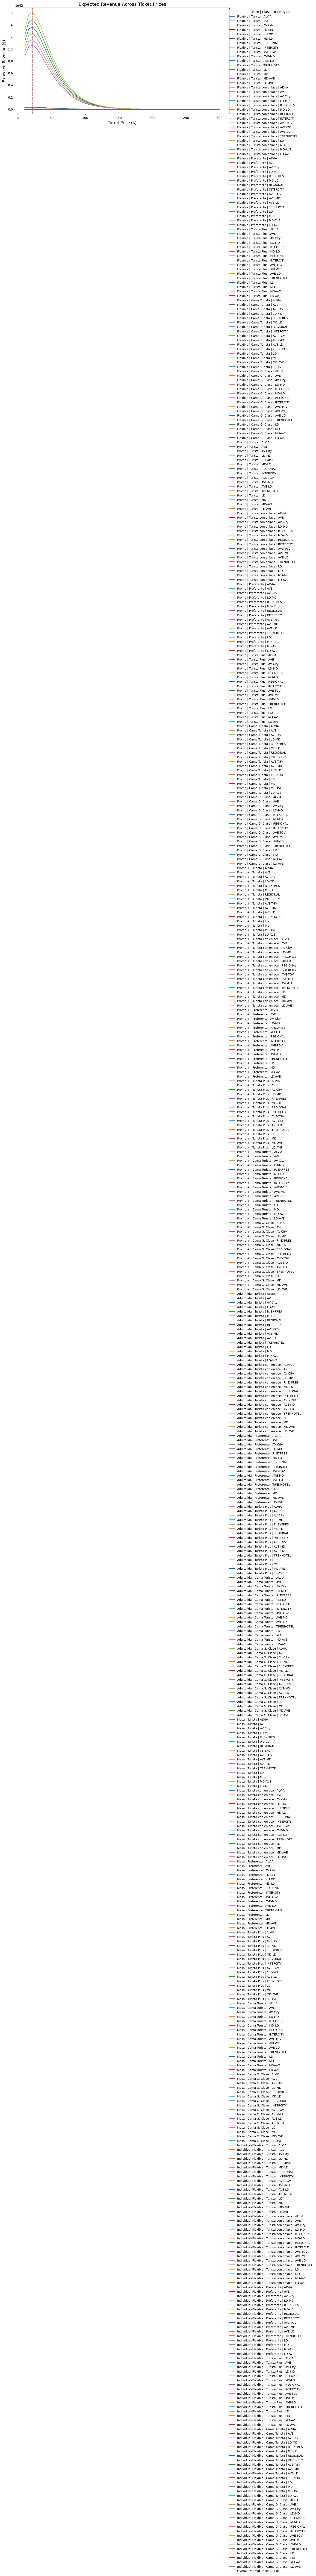

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure size
plt.figure(figsize=(12, 6))

optimal_prices_per_category = {}

# Plot revenue curves for each fare-class-train type combination
for category_tuple, revenue_curve in revenue_results.items():
    # Ensure category_tuple is valid
    if not isinstance(category_tuple, tuple) or len(category_tuple) != 3:
        print(f"Skipping invalid label: {category_tuple}")
        continue

    fare_code, class_code, train_code = category_tuple

    # Reverse encode category names
    fare_label = mapping["fare"].get(fare_code, f"Unknown {fare_code}")
    class_label = mapping["train_class"].get(class_code, f"Unknown {class_code}")
    train_label = mapping["train_type"].get(train_code, f"Unknown {train_code}")

    # Create readable label
    readable_label = f"{fare_label} | {class_label} | {train_label}"

    # Ensure revenue_curve length matches price_range
    if revenue_curve.shape[0] != len(price_range):
        print(f"Warning: Revenue curve length mismatch for {category_tuple}")
        continue

    # Find optimal price for this specific category
    optimal_index = np.argmax(revenue_curve)  # Find best index
    if optimal_index >= len(price_range):
        optimal_index = len(price_range) - 1  # Ensure within bounds

    optimal_price = float(price_range[optimal_index])  # Convert to scalar

    # Store category-specific optimal price
    optimal_prices_per_category[category_tuple] = optimal_price

    # Plot revenue curve
    plt.plot(price_range, revenue_curve, label=readable_label)

# Find the overall optimal price (most frequent or median value)
all_optimal_prices = list(optimal_prices_per_category.values())
overall_optimal_price = np.median(all_optimal_prices)  # More stable than max()

# Highlight overall optimal price with a vertical dashed line
plt.axvline(overall_optimal_price, color='red', linestyle="--", label=f"Overall Optimal Price: ${overall_optimal_price:.2f}")

# Label the plot
plt.xlabel("Ticket Price ($)", fontsize=12)
plt.ylabel("Expected Revenue ($)", fontsize=12)
plt.title("Expected Revenue Across Ticket Prices", fontsize=14)

# Adjust legend position for clarity
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), title="Fare | Class | Train Type", fontsize=9)

# Show the plot
plt.show()


#### Function to dynamically suggest best pricing per category 

In [92]:
def find_optimal_prices(revenue_results, price_range):
    """
    Find the optimal ticket price for each fare, class and train type combo
    
    Parameters:
    revenue_results (dict): Dictionary mapping category label to revenue arrays
    price_range (np.array): Arry of ticket price points
    
    Output:
        dict: Optimal price per category combo
    """
    optimal_prices = {}
    
    for label, revenue in revenue_results.items():
        optimal_index = np.argmax(revenue) # Find index of max revenue
        optimal_price = float(price_range[optimal_index]) # Get price at that index
        optimal_prices[label] = optimal_price
    return optimal_prices

# Call function
optimal_prices_per_category = find_optimal_prices(revenue_results, price_range)

# Save to csv
optimal_prices_df = pd.DataFrame(list(optimal_prices_per_category.items()), columns=['Category', 'Optimal Price'])
optimal_prices_df.to_csv('optimal_ticket_prices.csv', index=False)

# Display results
for category, price in optimal_prices_per_category.items():
    print(f'Optimal price for {category}: ${price:.2f}')

Optimal price for (1, 3, 0): $21.84
Optimal price for (1, 3, 2): $21.84
Optimal price for (1, 3, 1): $21.84
Optimal price for (1, 3, 9): $21.84
Optimal price for (1, 3, 13): $21.84
Optimal price for (1, 3, 12): $21.84
Optimal price for (1, 3, 14): $21.84
Optimal price for (1, 3, 6): $21.84
Optimal price for (1, 3, 5): $21.84
Optimal price for (1, 3, 4): $21.84
Optimal price for (1, 3, 3): $21.84
Optimal price for (1, 3, 15): $21.84
Optimal price for (1, 3, 7): $21.84
Optimal price for (1, 3, 10): $21.84
Optimal price for (1, 3, 11): $21.84
Optimal price for (1, 3, 8): $21.84
Optimal price for (1, 5, 0): $21.84
Optimal price for (1, 5, 2): $21.84
Optimal price for (1, 5, 1): $21.84
Optimal price for (1, 5, 9): $21.84
Optimal price for (1, 5, 13): $21.84
Optimal price for (1, 5, 12): $21.84
Optimal price for (1, 5, 14): $21.84
Optimal price for (1, 5, 6): $21.84
Optimal price for (1, 5, 5): $21.84
Optimal price for (1, 5, 4): $21.84
Optimal price for (1, 5, 3): $21.84
Optimal price for (

/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_8123/1713625884.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  optimal_price = float(price_range[optimal_index]) # Get price at that index


## Conclusion:
1. Leverage Demand Elasticity:
    * if demand is highly sensitive to price ($β$ is large and negative), small price changes can significantly impact sales.
    * If demand is inelastic ($β$ is near zero), price changes have little effect on demand.

2. Maximize Expected Revnue:
    * Plot expected revenue vs price and the price that maximizes it.
    * Ensure the chosen price balances profitability and sales volume.

3. Use Baysian Updating: Continue update the model as new data arrives.